# Domain Adaptation Analysis

## Load Packages

In [2]:
%matplotlib inline
import json
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib as mpl 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pyarrow as pa
import pyarrow.feather as feather
import os
warnings.filterwarnings("ignore","Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access", UserWarning)
# import classes from helper.py and data_simulator.py
from helper import *
from data_simulator import *
from copy import deepcopy
# import subset_search from causal_transfer_learning\code\subset_search.py
from causal_transfer_learning.code import subset_search
from causal_domain_adaptation import semiclass


In [3]:
# reset matplotlib rcParams and seaborn style
plt.rcParams = plt.rcParamsDefault
sns.set_style("ticks")
mpl.rcParams['figure.dpi'] = 400

## Nonlinear SCMs

In [11]:
# defines the relations between the variables through lambda functions.
relations = [lambda x,noise: np.random.uniform(-3,3)*x[1] + x[2] + noise,
             lambda x,noise: noise,
             lambda x,noise: noise,
             lambda x,noise: noise,
             lambda x,noise: x[0] + x[1] + x[6] + noise,
             lambda x,noise: x[2] + x[3] + x[4] + x[6] + noise,
             lambda x,noise: x[0] + x[1] + noise,]
# defines the noise distributions for each variable using the Distribution class.
distributions = [Distribution(np.random.normal,0,1,0,0.1),
                 Distribution(np.random.normal,0,1,0,0.1),
                 Distribution(np.random.normal,0,1,0,0.2),
                 Distribution(np.random.standard_t,0,1,4),
                 Distribution(np.random.standard_t,0,1,3),
                 Distribution(np.random.standard_cauchy),
                 Distribution(np.random.normal,0,1,0,0.1),]
# defines the order of generating the variables using 1-based indexing.
order = np.array([4,2,3,1,7,5,6]) - 1

In [12]:
my_simulator = NonlinearDataSimulator(relations,distributions,10,order)
df0 = my_simulator.simulate(env=0)
# print first three rows of the simulated data
df0.head(3)

X1        X2        X3        X4        X5        X6         Y
0 -0.390267 -0.213492 -0.052665  0.196312  1.953067  2.625461 -0.555718
1 -0.185156  0.018544 -0.035117  0.197215 -1.518920  1.643435 -0.108516
2 -0.115207  0.067841  0.140941 -0.007279 -2.449225 -2.032738 -0.104057

## Linear SCMs

### Example 

In [37]:
# manually defines the adjacency matrix of the graph. It is a numpy array.
p=7
adj_matrix = np.zeros((p,p))
edges = [(1,0),(2,0),(0,4),(1,4),(6,4),(2,5),(3,5),(4,5),(6,5),(0,6),(1,6)]
for edge in edges:
    adj_matrix[edge] = np.random.uniform(-3,3)

# or -------
# defines the number of nodes in the graph
p = 7
# defines the adjacency matrix of the graph using the DAGGenerator class from helper.py
dag_generator = DAGGenerator()
# generate a DAG with type='causal' or 'anticausal' or 'mixed'
adj_matrix, nodes = dag_generator.generate(p=p, type='causal')
# personalized modification
adj_matrix[3,1]=0 
adj_matrix[2,5]=0
adj_matrix[4,1]=0
adj_matrix[3,4]=0
# plot the generated DAG
plot_generated_dag(adj_matrix,nodes,hidden_nodes=None)
# check if the generated DAG is valid
dag_check_result = check_dags([(adj_matrix,nodes)])
# check if there are isolated nodes
print('No isolated nodes!' if nx.number_of_isolates(nx.DiGraph(adj_matrix))==0 else 'There are isolated nodes!')

In [20]:
# defines the noise distributions for each variable using the Distribution class.
distributions = [Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.standard_t,0,1,0.5),
                 Distribution(np.random.normal,0,1,0,0.1),
                 Distribution(np.random.standard_t,0,1,3),
                 Distribution(np.random.standard_cauchy),
                 Distribution(np.random.normal,0,1,0,0.1),]

In [21]:
# create a simulator
my_linear_simulator = LinearDataSimulator(adj_matrix,distributions,n_sample = 10)
# simulate observational data
obs_data = my_linear_simulator.simulate(env=0)
# causal information of the generated DAG w.r.t Y
causal_info = my_linear_simulator.get_causal_info()
# index of the parents of node Y
causal_info["parents"]

{0, 1, 3, 4, 5}

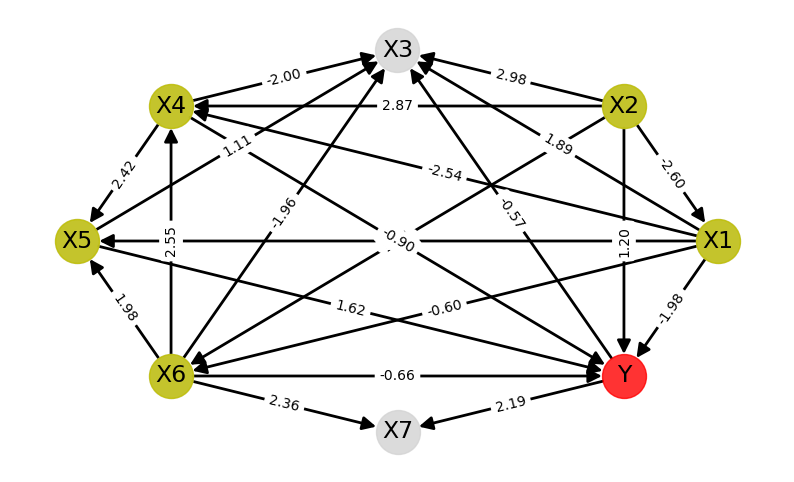

In [22]:
draw_simulation_model(adj_matrix=my_linear_simulator.adj_matrix,figsize=(10,6),invariantlist=list(causal_info["parents"]), weight=True)

### Experiments

Draw a DAG first.

In [118]:
# defines the number of nodes in the graph
p = 7
# defines the adjacency matrix of the graph using the DAGGenerator class from helper.py
dag_generator = DAGGenerator()
# generate a DAG with type='causal' or 'anticausal' or 'mixed'
adj_matrix, nodes = dag_generator.generate(p=p, type='mixed')
# personalized modification
adj_matrix[3,1]=0 
adj_matrix[2,5]=0
adj_matrix[4,1]=0
adj_matrix[3,4]=0


All DAGs are acyclic!
No isolated nodes!


In [125]:

# check if the generated DAG is valid
dag_check_result = check_dags([(adj_matrix,nodes)])
# check if there are isolated nodes
print('No isolated nodes!' if nx.number_of_isolates(nx.DiGraph(adj_matrix))==0 else 'There are isolated nodes!')

All DAGs are acyclic!
No isolated nodes!


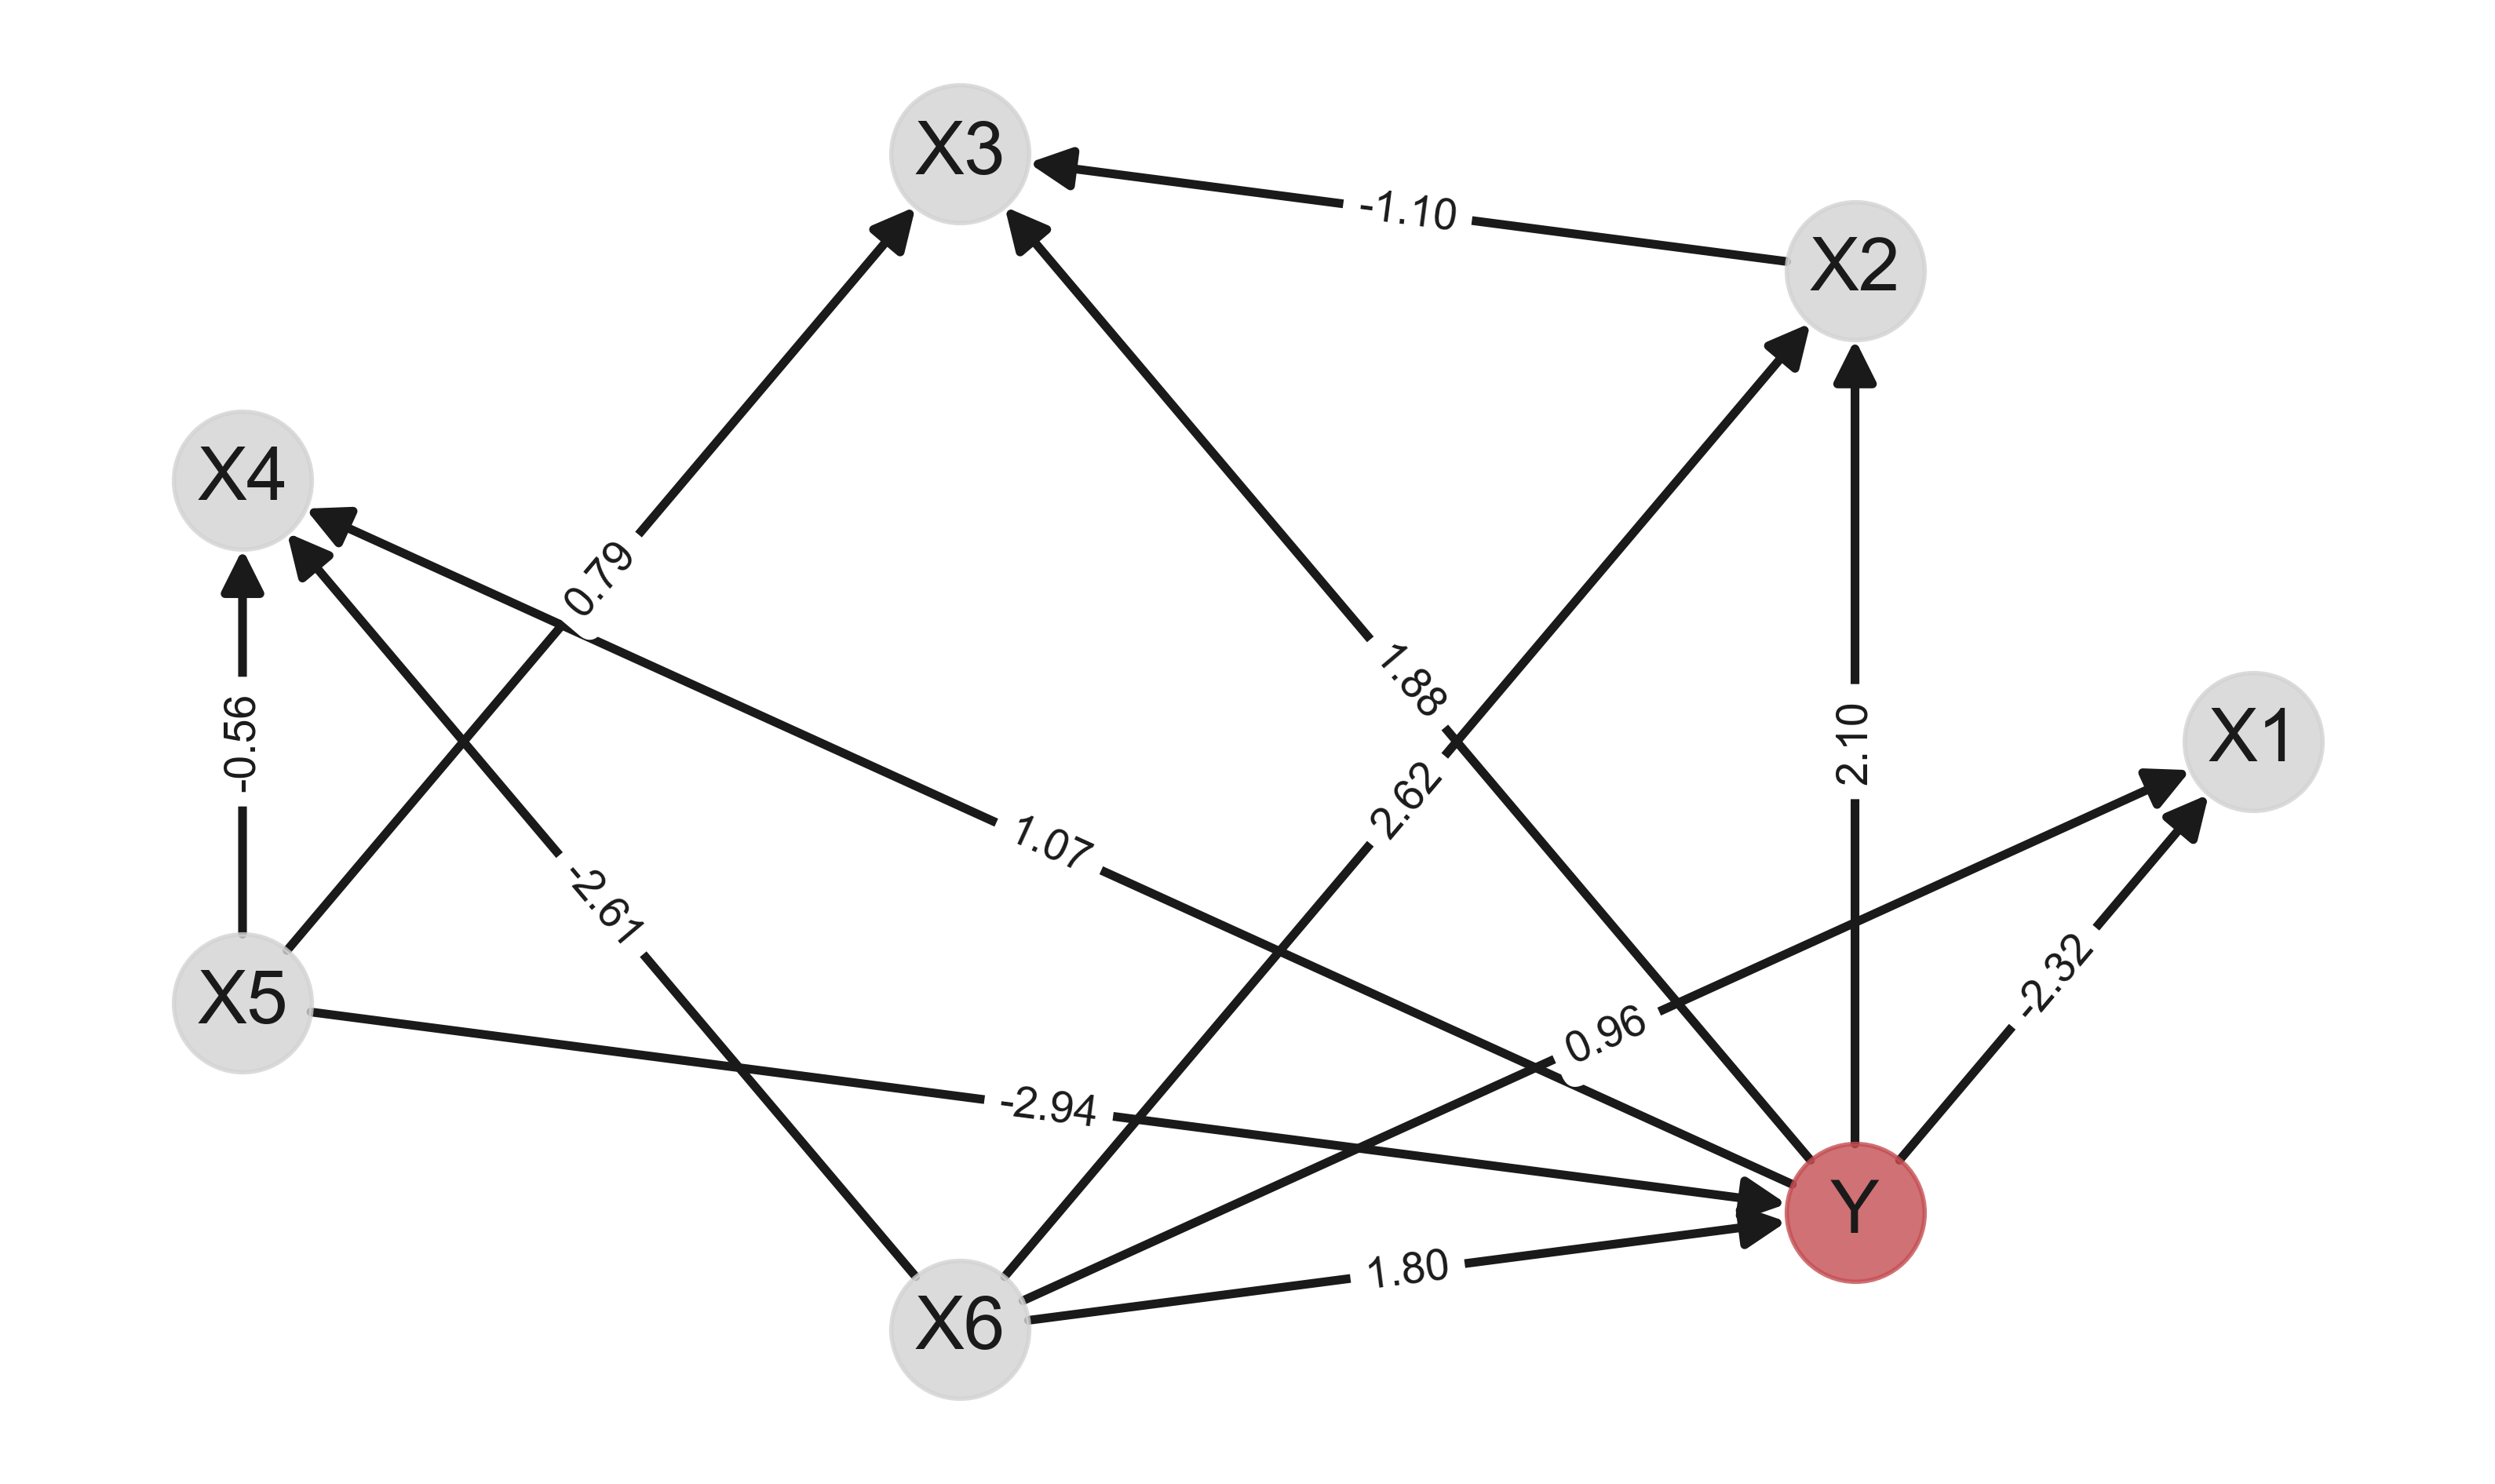

In [178]:
draw_simulation_model(adj_matrix=adj_matrix,figsize=(10,6), weight=True)

#### 1. Causal SCM

In [83]:
adj_causal = np.array([[0.0000, 0.0000, -2.0130, 0.0000, 0.0000, -1.6407, -1.2770],
       [-0.8196, 0.0000, -0.8108, 1.9916, 0.0000, -2.7240, -1.7236],
       [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.6447],
       [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7666],
       [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, -1.0709, -2.7412, 0.0000, -1.1047],
       [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
       
# defines the noise distributions for each variable using the Distribution class.
distributions = [Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.normal,0,1,0,0.5),
                 ]

# number of samples in each environment
n_sample = 300

# define intervention list, if one wants to use the observational dsitribution, just set it to None 
interventions = [{"type": None},# 0
                 {"type": "do", "intervene_Y": 0, "intervention_nodes": [1,3], "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 1
                 {"type": "do", "intervene_Y": 0, "intervention_nodes": [2,4], "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 2
                 {"type": "do", "intervene_Y": 1, "intervention_nodes": None, "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 3
                 {"type": "do", "intervene_Y": 2, "intervention_nodes": [5], "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 4
                 {"type": "mean_shift", "intervene_Y": 0, "intervention_nodes": [1,3], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 5
                 {"type": "mean_shift", "intervene_Y": 0, "intervention_nodes": [2,4], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 6
                 {"type": "mean_shift", "intervene_Y": 1, "intervention_nodes": None, "generator": Distribution(np.random.uniform,0,1,-1,1)},# 7
                 {"type": "mean_shift", "intervene_Y": 2, "intervention_nodes": [5], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 8
                 {"type": "variance_shift", "intervene_Y": 0, "intervention_nodes": [1,3], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 9
                 {"type": "variance_shift", "intervene_Y": 0, "intervention_nodes": [2,4], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 10
                 {"type": "variance_shift", "intervene_Y": 1, "intervention_nodes": None, "generator": Distribution(np.random.uniform,0,1,-1,1)},# 11
                 {"type": "variance_shift", "intervene_Y": 2, "intervention_nodes": [5], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 12
                 {"type": "distribution_shift", "intervene_Y": 0, "intervention_nodes": [1,3], "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 13
                 {"type": "distribution_shift", "intervene_Y": 0, "intervention_nodes": [2,4], "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 14
                 {"type": "distribution_shift", "intervene_Y": 1, "intervention_nodes": None, "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 15
                 {"type": "distribution_shift", "intervene_Y": 2, "intervention_nodes": [5], "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 16
                 {"type": "causal_effects", "intervene_Y": 0, "intervention_nodes": [1,3], "scaling_factor": 1.5},# 17
                 {"type": "causal_effects", "intervene_Y": 0, "intervention_nodes": [1,3], "scaling_factor": 1.02},# 18
                 {"type": "causal_effects", "intervene_Y": 0, "intervention_nodes": [2,4], "scaling_factor": 1.5},# 19
                 {"type": "causal_effects", "intervene_Y": 1, "intervention_nodes": None, "scaling_factor": 1.5},# 20
                 {"type": "causal_effects", "intervene_Y": 2, "intervention_nodes": [5], "scaling_factor": 1.5},# 21
                 {"type": "do", "intervene_Y": 0, "intervention_nodes": [3,5], "new_distribution": Distribution(np.random.normal,0,1,0,1)}# target domain
                 ]

# number of environments
n_environments = len(interventions)


# select the list of environments as source data and list of environments as target data
SOURCE_ENVS = [0,1,2] # [0,1,2], 
TARGET_ENV = n_environments-1
TARGET_TEST = n_environments-1

# run all methods 
repeats= 100

# Parameters for methods using dictionary as input
lamL2 = 0.
lamL1 = 0.
lamMatch = 10.
lamSCIC = 1.
wayMatch = 'mean'
# Methods use dictionary as input
methods_use_dict = [
           semiclass.OraTar(lamL2=lamL2),
           semiclass.SrcPool(lamL2=lamL2), 
           semiclass.SDIPOracle(lamMatch=lamMatch, lamL2=lamL2, sourceInd=0), 
           semiclass.SDIP(lamMatch=lamMatch, lamL2=lamL2, sourceInd=0), 
           semiclass.SDIPweigh(lamMatch=lamMatch, lamL2=lamL2,weightrho=1000.),
           semiclass.SCIC(lamSCIC=lamSCIC, lamL2=lamL2), 
           semiclass.CIRMweigh(lamSCIC=lamSCIC, lamMatch=lamMatch, lamL2=lamL2),
          ]

# Methods use dataframes as input
methods_use_df = ['SubSearch','GreedySubSearch','CauPa','UseMarkovBlanket','UseChildren','UseAncestors','UseAll']

# Regularization parameters
regularization = 'ridge' # or 'ridge', or None for no regularization
alpha = 0.05 # regularization strength, only used if regularization is lasso or ridge

# Parameters for methods using dataframe as input
df_paras = {'SubSearch':{'valid_split':0.3,'delta':0.05, 'use_hsic':True},'GreedySubSearch':{'valid_split':0.5,'delta':0.05, 'use_hsic':True}}


#### 2. Anticausal SCM

In [94]:
adj_anticausal = np.array([[ 0.        , -2.56057534,  0.        ,  0.50197407, -1.12793313,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.40436831,  0.        ,
        -0.87387668,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.89203313,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.6258574 , -0.87378998,  0.        ,
         0.        ,  0.        ],
       [ 1.43243704,  2.85352641,  0.        , -1.22637363,  2.42812684,
        -2.83852012,  0.        ]])
       
# defines the noise distributions for each variable using the Distribution class.
distributions = [Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.normal,0,1,0,0.5),
                 Distribution(np.random.normal,0,1,0,0.5),
                 ]

# number of samples in each environment
n_sample = 300

# define intervention list, if one wants to use the observational dsitribution, just set it to None 
interventions = [{"type": None},# 0
                 {"type": "do", "intervene_Y": 0, "intervention_nodes": [0,4], "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 1
                 {"type": "do", "intervene_Y": 0, "intervention_nodes": [3], "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 2
                 {"type": "do", "intervene_Y": 1, "intervention_nodes": None, "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 3
                 {"type": "do", "intervene_Y": 2, "intervention_nodes": [1,5], "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 4
                 {"type": "mean_shift", "intervene_Y": 0, "intervention_nodes": [0,4], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 5
                 {"type": "mean_shift", "intervene_Y": 0, "intervention_nodes": [3], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 6
                 {"type": "mean_shift", "intervene_Y": 1, "intervention_nodes": None, "generator": Distribution(np.random.uniform,0,1,-1,1)},# 7
                 {"type": "mean_shift", "intervene_Y": 2, "intervention_nodes": [1,5], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 8
                 {"type": "variance_shift", "intervene_Y": 0, "intervention_nodes": [0,4], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 9
                 {"type": "variance_shift", "intervene_Y": 0, "intervention_nodes": [3], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 10
                 {"type": "variance_shift", "intervene_Y": 1, "intervention_nodes": None, "generator": Distribution(np.random.uniform,0,1,-1,1)},# 11
                 {"type": "variance_shift", "intervene_Y": 2, "intervention_nodes": [1,5], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 12
                 {"type": "distribution_shift", "intervene_Y": 0, "intervention_nodes": [0,4], "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 13
                 {"type": "distribution_shift", "intervene_Y": 0, "intervention_nodes": [3], "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 14
                 {"type": "distribution_shift", "intervene_Y": 1, "intervention_nodes": None, "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 15
                 {"type": "distribution_shift", "intervene_Y": 2, "intervention_nodes": [1,5], "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 16
                 {"type": "causal_effects", "intervene_Y": 0, "intervention_nodes": [0,4], "scaling_factor": 1.5},# 17
                 {"type": "causal_effects", "intervene_Y": 0, "intervention_nodes": [0,4], "scaling_factor": 1.02},# 18
                 {"type": "causal_effects", "intervene_Y": 0, "intervention_nodes": [3], "scaling_factor": 1.5},# 19
                 {"type": "causal_effects", "intervene_Y": 1, "intervention_nodes": None, "scaling_factor": 1.5},# 20
                 {"type": "causal_effects", "intervene_Y": 2, "intervention_nodes": [1,5], "scaling_factor": 1.5},# 21
                 {"type": "mean_shift", "intervene_Y": 1, "intervention_nodes": None, "generator": Distribution(np.random.uniform,0,1,-1,1)}# target domain
                 ]

# number of environments
n_environments = len(interventions)


# select the list of environments as source data and list of environments as target data
SOURCE_ENVS = [0,5,6,8] # [0,5,6,8]
TARGET_ENV = n_environments-1
TARGET_TEST = n_environments-1

# run all methods 
repeats= 100

# Parameters for methods using dictionary as input
lamL2 = 0.
lamL1 = 0.
lamMatch = 10.
lamSCIC = 1.
wayMatch = 'mean'
# Methods use dictionary as input
methods_use_dict = [
           semiclass.OraTar(lamL2=lamL2),
           semiclass.SrcPool(lamL2=lamL2), 
           semiclass.SDIPOracle(lamMatch=lamMatch, lamL2=lamL2, sourceInd=0), 
           semiclass.SDIP(lamMatch=lamMatch, lamL2=lamL2, sourceInd=0), 
           semiclass.SDIPweigh(lamMatch=lamMatch, lamL2=lamL2,weightrho=1000.),
           semiclass.SCIC(lamSCIC=lamSCIC, lamL2=lamL2), 
           semiclass.CIRMweigh(lamSCIC=lamSCIC, lamMatch=lamMatch, lamL2=lamL2,weightrho=1000.),
          ]

# Methods use dataframes as input
methods_use_df = ['SubSearch','GreedySubSearch','CauPa','UseMarkovBlanket','UseChildren','UseAncestors','UseAll']

# Regularization parameters
regularization = 'ridge' # or 'ridge', or None for no regularization
alpha = 0.05 # regularization strength, only used if regularization is lasso or ridge

# Parameters for methods using dataframe as input
df_paras = {'SubSearch':{'valid_split':0.3,'delta':0.05, 'use_hsic':True},'GreedySubSearch':{'valid_split':0.5,'delta':0.05, 'use_hsic':True}}


#### 3. Hypbrid SCM

In [181]:
adj_hybrid = np.array([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, -1.1020, 0.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.7900, -0.5617, 0.0000, 0.0000, -2.9365],
       [0.9620, 2.6244, 0.0000, -2.6127, 0.0000, 0.0000, 1.7960],
       [-2.3208, 2.0980, 1.8786, 1.0722, 0.0000, 0.0000, 0.0000]])
       
# defines the noise distributions for each variable using the Distribution class.
distributions = [Distribution(np.random.normal,0,1,0,0.5),
                Distribution(np.random.normal,0,1,0,0.5),
                Distribution(np.random.normal,0,1,0,0.5),
                Distribution(np.random.normal,0,1,0,0.5),
                Distribution(np.random.normal,0,1,0,0.5),
                Distribution(np.random.normal,0,1,0,0.5),
                Distribution(np.random.normal,0,1,0,0.5),
                ]

# distributions = [Distribution(np.random.gamma,0,1,2,2),
#                  Distribution(np.random.gamma,0,1,2,2),
#                  Distribution(np.random.gamma,0,1,2,2),
#                  Distribution(np.random.gamma,0,1,2,2),
#                  Distribution(np.random.gamma,0,1,2,2),
#                  Distribution(np.random.gamma,0,1,2,2),
#                  Distribution(np.random.gamma,0,1,2,2),
#                 ]


# number of samples in each environment
n_sample = 300

# define intervention list, if one wants to use the observational dsitribution, just set it to None 
interventions = [{"type": None},# 0
                 {"type": "do", "intervene_Y": 0, "intervention_nodes": [0], "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 1
                 {"type": "do", "intervene_Y": 0, "intervention_nodes": [3], "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 2
                 {"type": "do", "intervene_Y": 1, "intervention_nodes": None, "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 3
                 {"type": "do", "intervene_Y": 2, "intervention_nodes": [2], "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 4
                 {"type": "mean_shift", "intervene_Y": 0, "intervention_nodes": [0], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 5
                 {"type": "mean_shift", "intervene_Y": 0, "intervention_nodes": [3], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 6
                 {"type": "mean_shift", "intervene_Y": 1, "intervention_nodes": None, "generator": Distribution(np.random.uniform,0,1,-1,1)},# 7
                 {"type": "mean_shift", "intervene_Y": 2, "intervention_nodes": [2], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 8
                 {"type": "variance_shift", "intervene_Y": 0, "intervention_nodes": [0], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 9
                 {"type": "variance_shift", "intervene_Y": 0, "intervention_nodes": [3], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 10
                 {"type": "variance_shift", "intervene_Y": 1, "intervention_nodes": None, "generator": Distribution(np.random.uniform,0,1,-1,1)},# 11
                 {"type": "variance_shift", "intervene_Y": 2, "intervention_nodes": [2], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 12
                 {"type": "distribution_shift", "intervene_Y": 0, "intervention_nodes": [0], "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 13
                 {"type": "distribution_shift", "intervene_Y": 0, "intervention_nodes": [3], "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 14
                 {"type": "distribution_shift", "intervene_Y": 1, "intervention_nodes": None, "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 15
                 {"type": "distribution_shift", "intervene_Y": 2, "intervention_nodes": [2], "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 16
                 {"type": "causal_effects", "intervene_Y": 0, "intervention_nodes": [0], "scaling_factor": 1.5},# 17
                 {"type": "causal_effects", "intervene_Y": 0, "intervention_nodes": [0], "scaling_factor": 1.02},# 18
                 {"type": "causal_effects", "intervene_Y": 0, "intervention_nodes": [3], "scaling_factor": 1.5},# 19
                 {"type": "causal_effects", "intervene_Y": 1, "intervention_nodes": None, "scaling_factor": 1.5},# 20
                 {"type": "causal_effects", "intervene_Y": 2, "intervention_nodes": [2], "scaling_factor": 1.5},# 21
                 {"type": "causal_effects", "intervene_Y": 1, "intervention_nodes": None, "scaling_factor": 1.02},# target domain
                 {"type": "mean_shift", "intervene_Y": 0, "intervention_nodes": [0,3], "generator": Distribution(np.random.uniform,0,1,-1,1)}]

# number of environments
n_environments = len(interventions)


# select the list of environments as source data and list of environments as target data
SOURCE_ENVS = [1,5,6,11,14,16] # 
TARGET_ENV = n_environments-1
TARGET_TEST = n_environments-1

# run all methods 
repeats= 100

# Parameters for methods using dictionary as input
lamL2 = 0.
lamL1 = 0.
lamMatch = 10.
lamSCIC = 1.
wayMatch = 'mean'
# Methods use dictionary as input
methods_use_dict = [
           semiclass.OraTar(lamL2=lamL2),
           semiclass.SrcPool(lamL2=lamL2), 
           semiclass.SDIPOracle(lamMatch=lamMatch, lamL2=lamL2, sourceInd=0), 
           semiclass.SDIPmix(causal_index=[4,5],lamMatch=lamMatch, lamL2=lamL2, sourceInd=0),
           semiclass.SDIPweigh(lamMatch=lamMatch, lamL2=lamL2,weightrho=1000.),
           semiclass.SCIC(lamSCIC=lamSCIC, lamL2=lamL2), 
           semiclass.CIRMweigh(lamSCIC=lamSCIC, lamMatch=lamMatch, lamL2=lamL2,weightrho=1000.),
           semiclass.CIRMmixweigh(causal_index=[4,5],lamSCIC=lamSCIC,lamMatch=lamMatch, lamL2=lamL2, weightrho=1000.),
          ]

# Methods use dataframes as input
methods_use_df = ['SubSearch','GreedySubSearch','CauPa','UseMarkovBlanket','UseChildren','UseAncestors','UseAll']

# Regularization parameters
regularization = 'ridge' # or 'ridge', or None for no regularization
alpha = 0.05 # regularization strength, only used if regularization is lasso or ridge

# Parameters for methods using dataframe as input
df_paras = {'SubSearch':{'valid_split':0.3,'delta':0.05, 'use_hsic':True},'GreedySubSearch':{'valid_split':0.5,'delta':0.05, 'use_hsic':True}}


Now run the algorithms.

In [165]:
res_all, res_all_test, names, names_short,all_data = repeat_all_on_a_DAG(repeats=repeats,
n_environments=n_environments,
adj_matrix=adj_matrix,
distributions=distributions,
n_sample=n_sample,
interventions=interventions,
source_envs=SOURCE_ENVS,
target_env=TARGET_ENV,
methods_use_dict=methods_use_dict,
target_test= TARGET_TEST,
methods_use_df=methods_use_df,
regularization=regularization,
alpha=alpha,
df_paras=df_paras)

In [166]:
print(len(all_data) == repeats)
print(all_data[0].int_nodes_history)
print(all_data[0].intervention_info)
print(all_data[0].base_model)
all_data[0]

True
[[], [0], [3], [6], [2, 6], [0], [3], [6], [2, 6], [0], [3], [6], [2, 6], [0], [3], [6], [2, 6], [0], [0], [3], [6], [2, 6], [6], [1, 3, 6]]
[None, "do_intervention: intervention_nodes=['X1'], new_distribution=normal, mean_shift:0, variance_shift:1, parameters:(0, 1)", "do_intervention: intervention_nodes=['X4'], new_distribution=normal, mean_shift:0, variance_shift:1, parameters:(0, 1)", "do_intervention: intervention_nodes=['Y'], new_distribution=normal, mean_shift:0, variance_shift:1, parameters:(0, 1)", "do_intervention: intervention_nodes=['X3', 'Y'], new_distribution=normal, mean_shift:0, variance_shift:1, parameters:(0, 1)", "mean_shift: intervention_nodes=['X1'], mean_shift=[-0.2646337624602437]", "mean_shift: intervention_nodes=['X4'], mean_shift=[0.23167258687873793]", "mean_shift: intervention_nodes=['Y'], mean_shift=[0.7634371382961342]", "mean_shift: intervention_nodes=['X3', 'Y'], mean_shift=[0.6431637190374877, 0.764281517699142]", "variance_shift: intervention_node

X1         X2        X3        X4        X5        X6         Y  \
0      0.426544  -3.694422  2.968242  1.072575 -0.085065 -0.749885 -0.554528   
1      0.506801  -1.365175  0.164065 -0.555796 -0.061362 -0.006245 -0.425893   
2      0.018863  -1.105478  0.247834  1.312920 -0.345467 -0.322168 -0.191745   
3     -1.196347   0.101956 -0.142372  2.023532 -0.281326 -0.188073  0.168572   
4     -3.804968   6.553437 -3.508335  0.507792 -0.006658  0.907719  1.972535   
...         ...        ...       ...       ...       ...       ...       ...   
7195  -0.065939   0.262275 -0.093858 -0.297984  0.130753 -0.050361  0.428760   
7196  -3.679912   1.152280  1.457693  2.882203 -0.531388 -0.754591  1.566690   
7197 -11.120779  11.355186 -4.272894  3.320139 -0.718460  0.646258  4.990439   
7198   1.584881   0.828940 -1.257378 -3.657167  0.567529  0.739390 -0.413968   
7199   2.018637  -2.466409  1.808246 -1.971430  0.821335  0.058237 -1.032678   

      env  
0       0  
1       0  
2       0  
3       0  
4       0  
...   ...  
7195   23  
7196   23  
7197   23  
7198   23  
7199   23  

[7200 rows x 8 columns]

## Hidden Variables

[[0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 -1.1020 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.7900 -0.5617 0.0000 0.0000 -2.9365]
 [0.9620 2.6244 0.0000 -2.6127 0.0000 0.0000 1.7960]
 [-2.3208 2.0980 1.8786 1.0722 0.0000 0.0000 0.0000]]


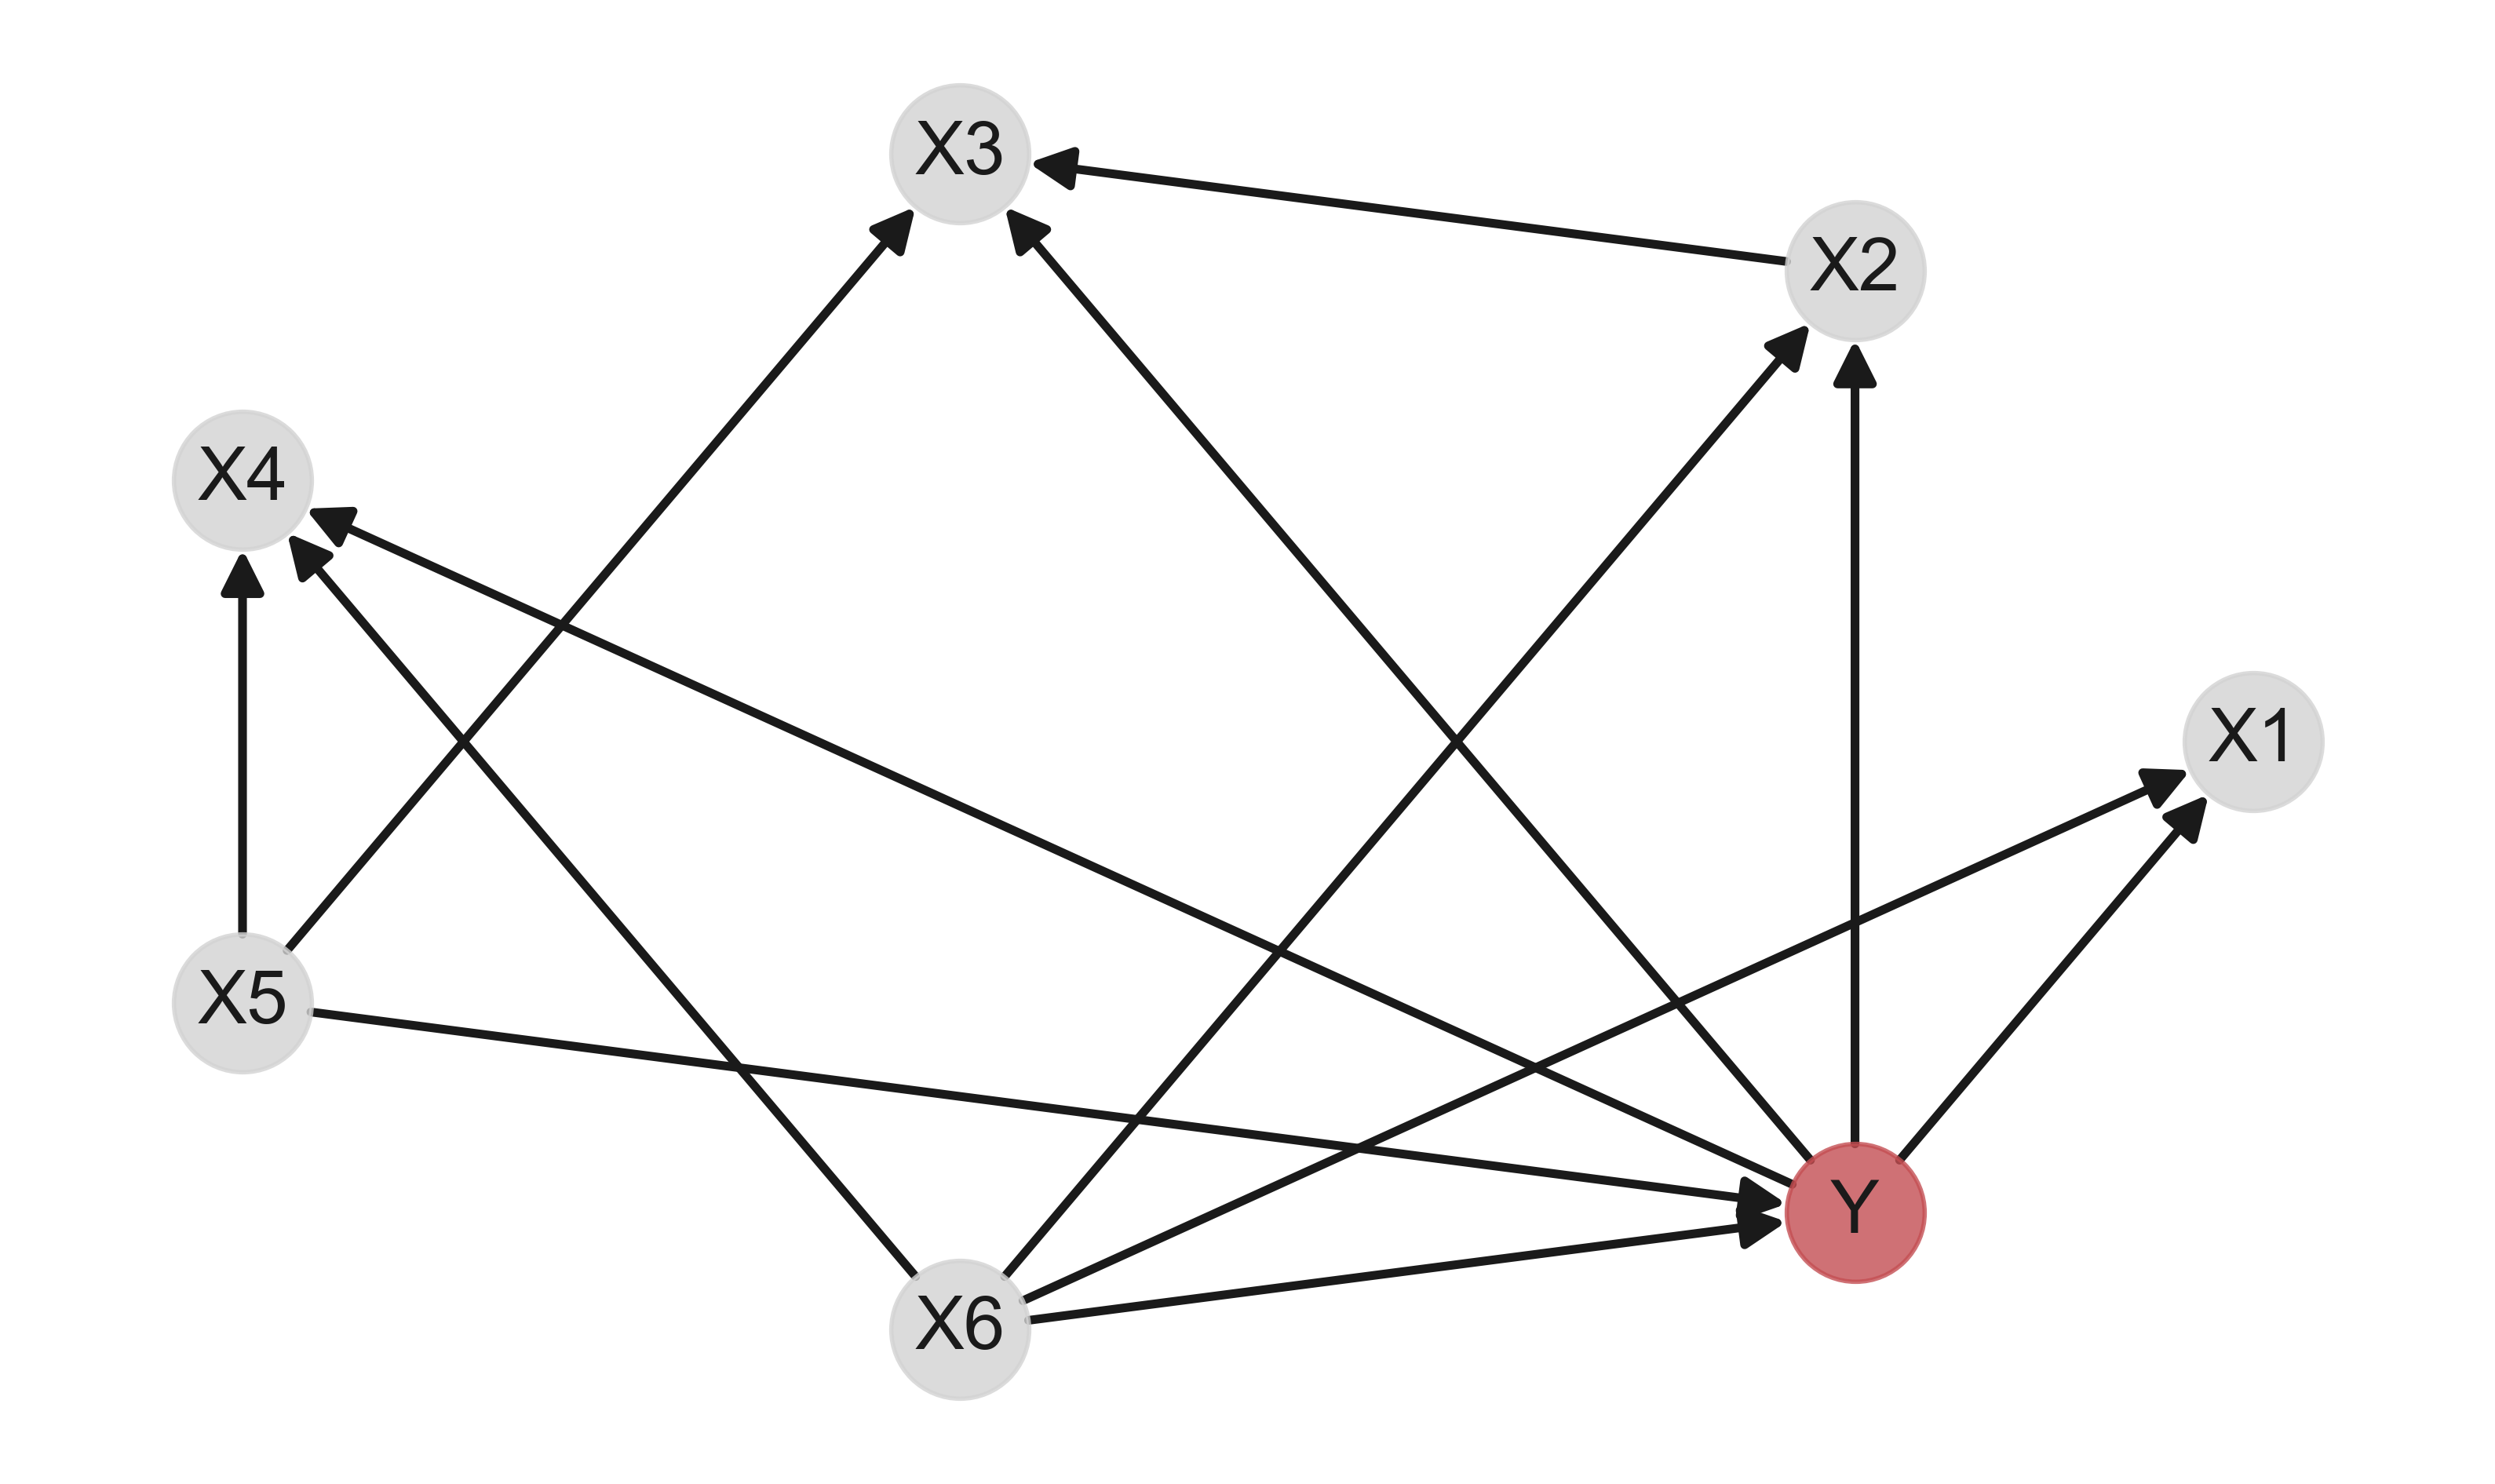

[[0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 -1.1020 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.7900 -0.5617 0.0000 0.0000 0.0000 0.0000 -2.9365]
 [0.9620 2.6244 0.0000 -2.6127 0.0000 0.0000 0.0000 0.0000 1.7960]
 [0.0000 -1.0382 -2.3173 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 2.8884 0.0000 0.0000 0.0000 1.1629]
 [-2.3208 2.0980 1.8786 1.0722 0.0000 0.0000 0.0000 0.0000 0.0000]]


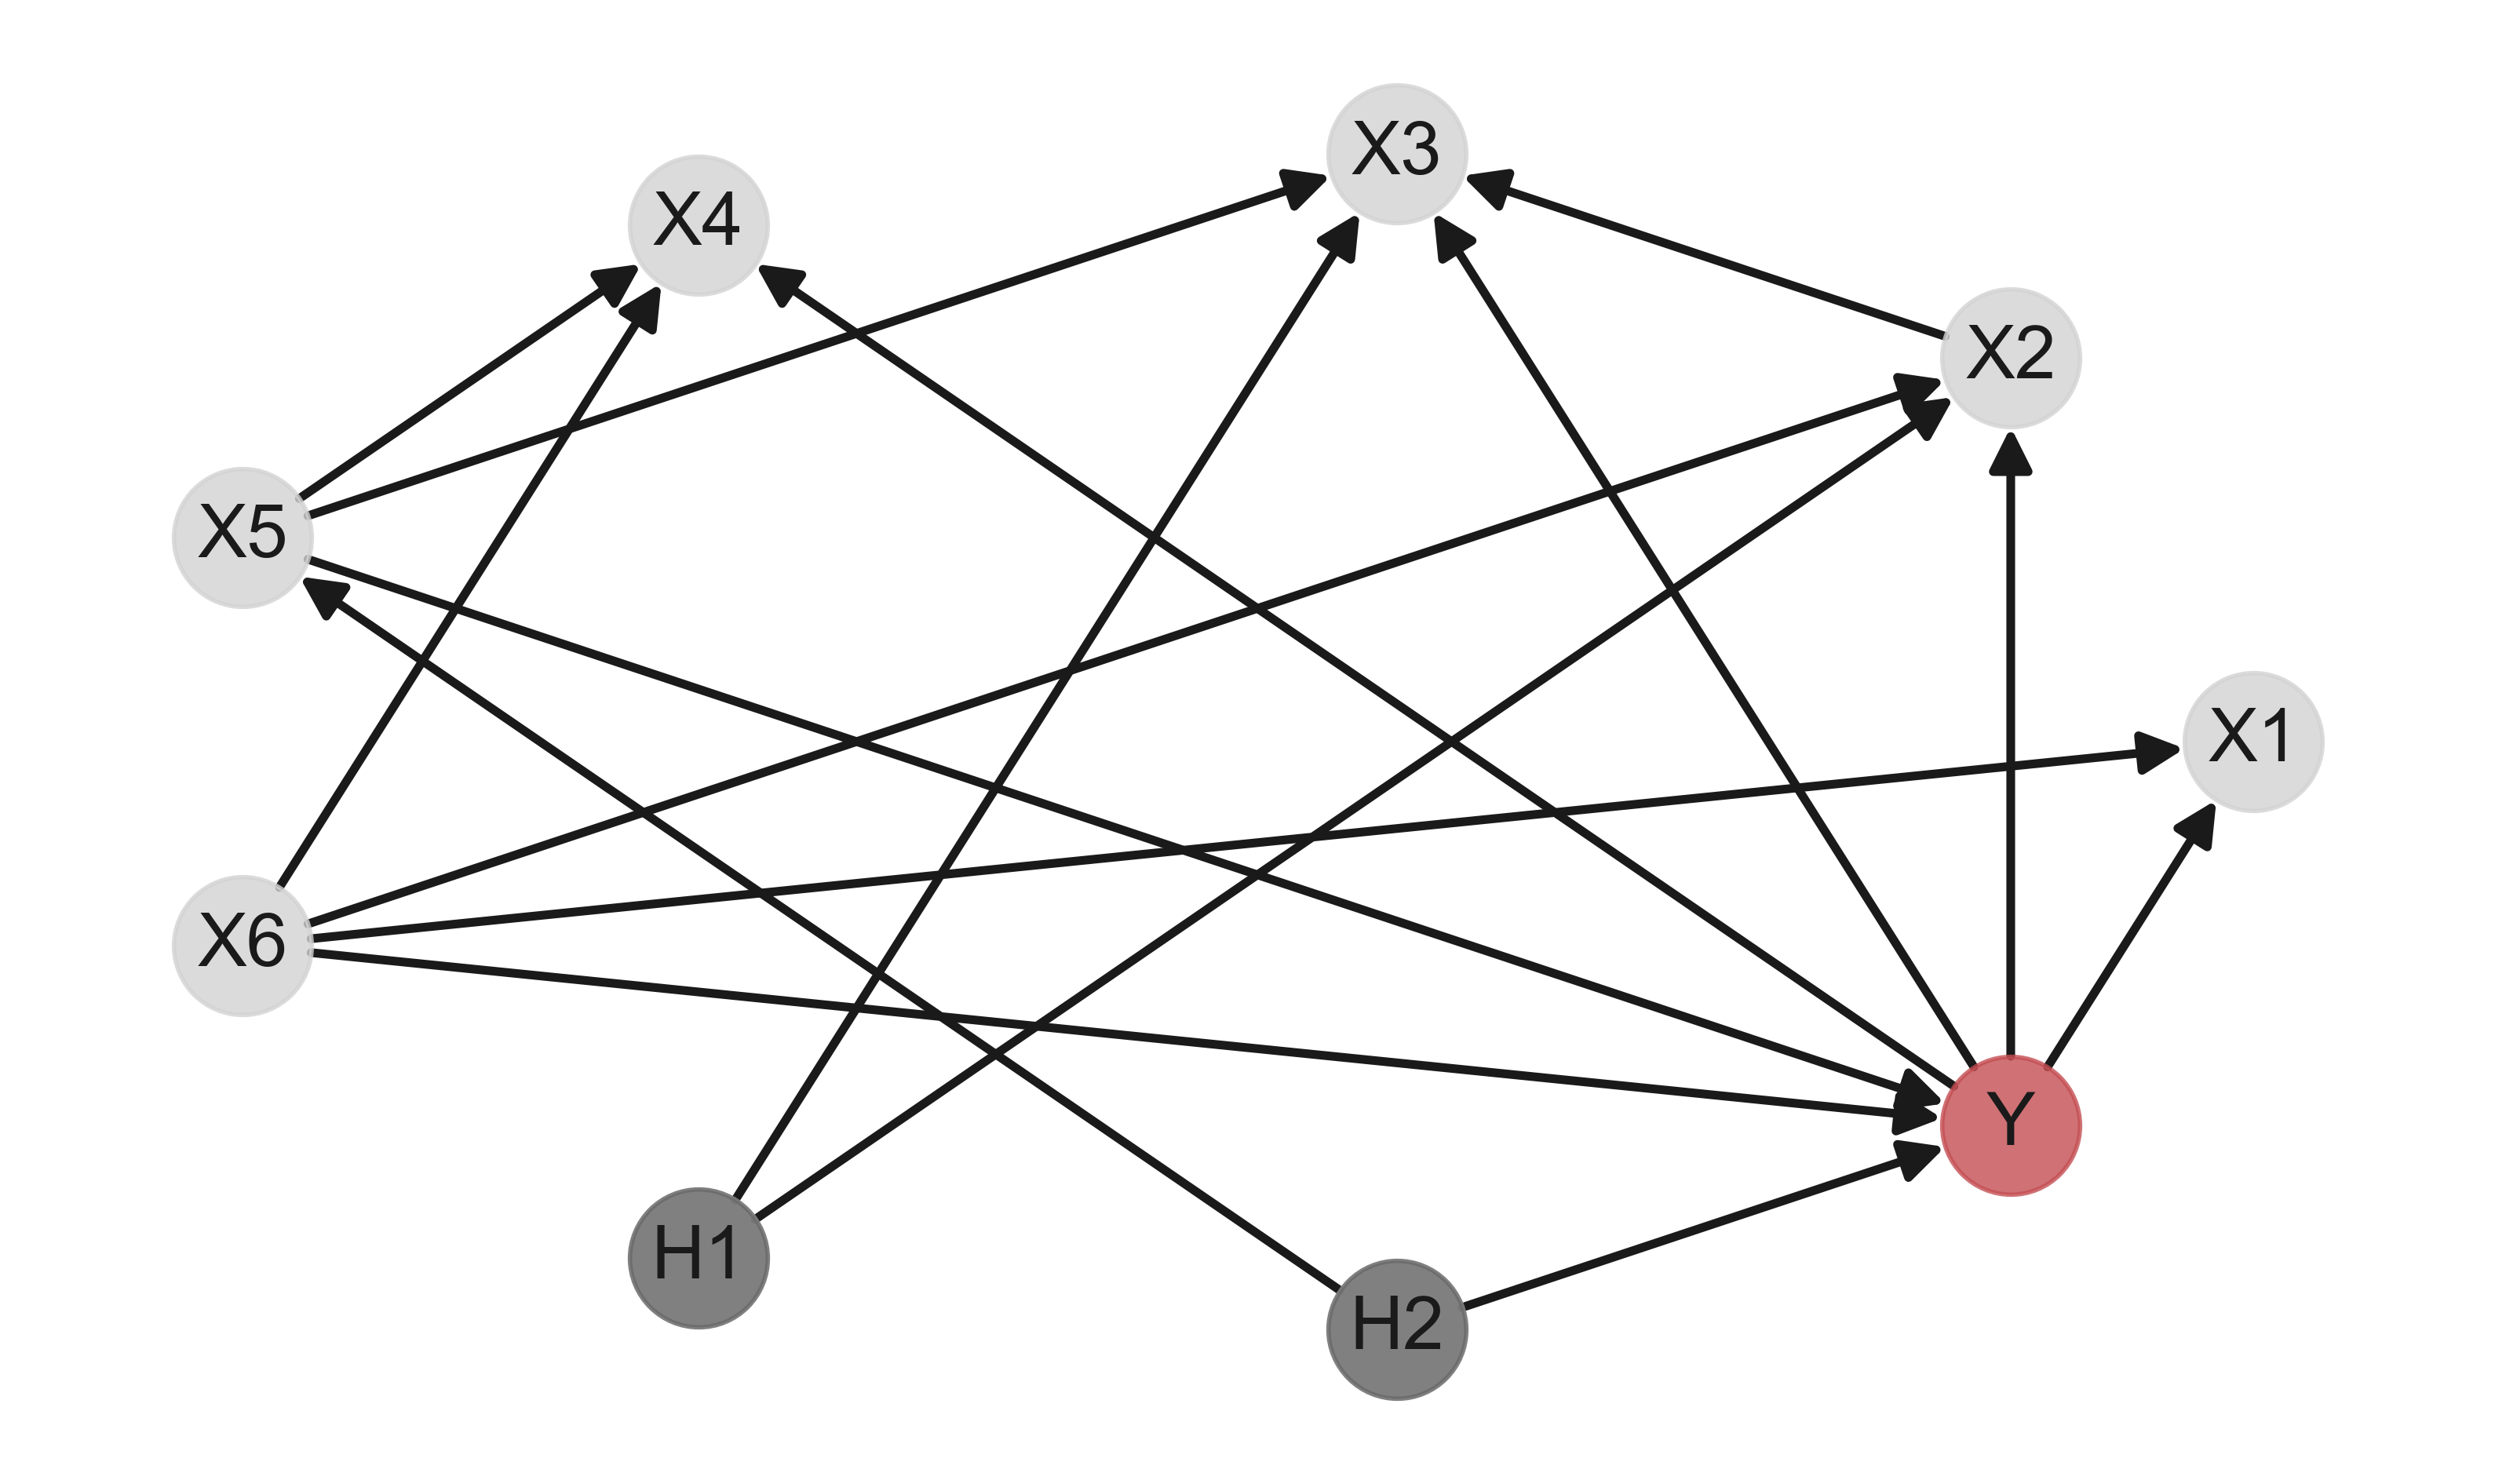

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'H1', 'H2', 'Y']
[6, 7]


In [205]:
# declare a list of 2-tuples that describes several hidden variables and their chidren, specifies y and 
hidden_nodes = [(1,2),(4,6)]
print(adj_matrix)
draw_simulation_model(adj_matrix=adj_matrix,figsize=(10,6),weight=False)

# add hidden nodes to the DAG
new_adj_matrix, hidden_nodes_index = add_hidden_nodes(adj_matrix,hidden_nodes)
print(new_adj_matrix)
# names of nodes in the new graph
new_nodes = nodes[:-1] + ['H'+str(i) for i in range(1,len(hidden_nodes)+1)]+['Y']
draw_simulation_model(adj_matrix=new_adj_matrix,figsize=(10,6),hiddenlist=hidden_nodes_index,weight=False)
print(new_nodes)
print(hidden_nodes_index)

In [206]:
adj_hybrid = np.array([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, -1.1020, 0.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.7900, -0.5617, 0.0000, 0.0000, -2.9365],
       [0.9620, 2.6244, 0.0000, -2.6127, 0.0000, 0.0000, 1.7960],
       [-2.3208, 2.0980, 1.8786, 1.0722, 0.0000, 0.0000, 0.0000]])
       
# defines the noise distributions for each variable using the Distribution class, should include the hidden variable noises
distributions = [Distribution(np.random.normal,0,1,0,0.5),
                Distribution(np.random.normal,0,1,0,0.5),
                Distribution(np.random.normal,0,1,0,0.5),
                Distribution(np.random.normal,0,1,0,0.5),
                Distribution(np.random.normal,0,1,0,0.5),
                Distribution(np.random.normal,0,1,0,0.5),
                Distribution(np.random.normal,0,1,0,0.5),
                Distribution(np.random.normal,0,1,0,0.5),
                Distribution(np.random.normal,0,1,0,0.5),
                ]

# distributions = [Distribution(np.random.gamma,0,1,2,2),
#                  Distribution(np.random.gamma,0,1,2,2),
#                  Distribution(np.random.gamma,0,1,2,2),
#                  Distribution(np.random.gamma,0,1,2,2),
#                  Distribution(np.random.gamma,0,1,2,2),
#                  Distribution(np.random.gamma,0,1,2,2),
#                  Distribution(np.random.gamma,0,1,2,2),
#                 ]


# number of samples in each environment
n_sample = 300

# define intervention list, if one wants to use the observational dsitribution, just set it to None 
interventions = [{"type": None},# 0
                 {"type": "do", "intervene_Y": 0, "intervention_nodes": [0], "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 1
                 {"type": "do", "intervene_Y": 0, "intervention_nodes": [3], "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 2
                 {"type": "do", "intervene_Y": 1, "intervention_nodes": None, "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 3
                 {"type": "do", "intervene_Y": 2, "intervention_nodes": [2], "new_distribution": Distribution(np.random.normal,0,1,0,1)},# 4
                 {"type": "mean_shift", "intervene_Y": 0, "intervention_nodes": [0], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 5
                 {"type": "mean_shift", "intervene_Y": 0, "intervention_nodes": [3], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 6
                 {"type": "mean_shift", "intervene_Y": 1, "intervention_nodes": None, "generator": Distribution(np.random.uniform,0,1,-1,1)},# 7
                 {"type": "mean_shift", "intervene_Y": 2, "intervention_nodes": [2], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 8
                 {"type": "variance_shift", "intervene_Y": 0, "intervention_nodes": [0], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 9
                 {"type": "variance_shift", "intervene_Y": 0, "intervention_nodes": [3], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 10
                 {"type": "variance_shift", "intervene_Y": 1, "intervention_nodes": None, "generator": Distribution(np.random.uniform,0,1,-1,1)},# 11
                 {"type": "variance_shift", "intervene_Y": 2, "intervention_nodes": [2], "generator": Distribution(np.random.uniform,0,1,-1,1)},# 12
                 {"type": "distribution_shift", "intervene_Y": 0, "intervention_nodes": [0], "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 13
                 {"type": "distribution_shift", "intervene_Y": 0, "intervention_nodes": [3], "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 14
                 {"type": "distribution_shift", "intervene_Y": 1, "intervention_nodes": None, "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 15
                 {"type": "distribution_shift", "intervene_Y": 2, "intervention_nodes": [2], "new_distribution": Distribution(np.random.uniform,0,1,-0.5,0.5)},# 16
                 {"type": "causal_effects", "intervene_Y": 0, "intervention_nodes": [0], "scaling_factor": 1.5},# 17
                 {"type": "causal_effects", "intervene_Y": 0, "intervention_nodes": [0], "scaling_factor": 1.02},# 18
                 {"type": "causal_effects", "intervene_Y": 0, "intervention_nodes": [3], "scaling_factor": 1.5},# 19
                 {"type": "causal_effects", "intervene_Y": 1, "intervention_nodes": None, "scaling_factor": 1.5},# 20
                 {"type": "causal_effects", "intervene_Y": 2, "intervention_nodes": [2], "scaling_factor": 1.5},# 21
                 {"type": "causal_effects", "intervene_Y": 1, "intervention_nodes": None, "scaling_factor": 1.02},# target domain
                 {"type": "mean_shift", "intervene_Y": 0, "intervention_nodes": [0,3], "generator": Distribution(np.random.uniform,0,1,-1,1)}]

# number of environments
n_environments = len(interventions)


# select the list of environments as source data and list of environments as target data
SOURCE_ENVS = [1,5,6,11,14,16] # 
TARGET_ENV = n_environments-1
TARGET_TEST = n_environments-1

# run all methods 
repeats= 100

# Parameters for methods using dictionary as input
lamL2 = 0.
lamL1 = 0.
lamMatch = 10.
lamSCIC = 1.
wayMatch = 'mean'
# Methods use dictionary as input
methods_use_dict = [
           semiclass.OraTar(lamL2=lamL2),
           semiclass.SrcPool(lamL2=lamL2), 
           semiclass.SDIPOracle(lamMatch=lamMatch, lamL2=lamL2, sourceInd=0), 
           semiclass.SDIPmix(causal_index=[4,5],lamMatch=lamMatch, lamL2=lamL2, sourceInd=0),
           semiclass.SDIPweigh(lamMatch=lamMatch, lamL2=lamL2,weightrho=1000.),
           semiclass.SCIC(lamSCIC=lamSCIC, lamL2=lamL2), 
           semiclass.CIRMweigh(lamSCIC=lamSCIC, lamMatch=lamMatch, lamL2=lamL2,weightrho=1000.),
           semiclass.CIRMmixweigh(causal_index=[4,5],lamSCIC=lamSCIC,lamMatch=lamMatch, lamL2=lamL2, weightrho=1000.),
          ]

# Methods use dataframes as input
methods_use_df = ['SubSearch','GreedySubSearch','CauPa','UseMarkovBlanket','UseChildren','UseAncestors','UseAll']

# Regularization parameters
regularization = 'ridge' # or 'ridge', or None for no regularization
alpha = 0.05 # regularization strength, only used if regularization is lasso or ridge

# Parameters for methods using dataframe as input
df_paras = {'SubSearch':{'valid_split':0.3,'delta':0.05, 'use_hsic':True},'GreedySubSearch':{'valid_split':0.5,'delta':0.05, 'use_hsic':True}}


In [207]:
res_all, res_all_test, names, names_short,all_data = repeat_all_on_a_hidden_DAG(repeats=repeats,
n_environments=n_environments,
adj_matrix_with_hidden=new_adj_matrix,
hidden_index= hidden_nodes_index,
distributions=distributions,
n_sample=n_sample,
interventions=interventions,
source_envs=SOURCE_ENVS,
target_env=TARGET_ENV,
methods_use_dict=methods_use_dict,
target_test= TARGET_TEST,
methods_use_df=methods_use_df,
regularization=regularization,
alpha=alpha,
df_paras=df_paras)

In [208]:
print(len(all_data) == repeats)
print(all_data[0].int_nodes_history)
print(all_data[0].intervention_info)
print(all_data[0].base_model) # model without hidden nodes
print(all_data[0].true_base_model) # model with hidden nodes
all_data[0]

True
[[], [0], [3], [6], [2, 6], [0], [3], [6], [2, 6], [0], [3], [6], [2, 6], [0], [3], [6], [2, 6], [0], [0], [3], [6], [2, 6], [6], [0, 3]]
[None, "do_intervention: intervention_nodes=['X1'], new_distribution=normal, mean_shift:0, variance_shift:1, parameters:(0, 1)", "do_intervention: intervention_nodes=['X4'], new_distribution=normal, mean_shift:0, variance_shift:1, parameters:(0, 1)", "do_intervention: intervention_nodes=['Y'], new_distribution=normal, mean_shift:0, variance_shift:1, parameters:(0, 1)", "do_intervention: intervention_nodes=['X3', 'Y'], new_distribution=normal, mean_shift:0, variance_shift:1, parameters:(0, 1)", "mean_shift: intervention_nodes=['X1'], mean_shift=[-0.021830393825096106]", "mean_shift: intervention_nodes=['X4'], mean_shift=[-0.2026567659379075]", "mean_shift: intervention_nodes=['Y'], mean_shift=[0.9905094754762569]", "mean_shift: intervention_nodes=['X3', 'Y'], mean_shift=[-0.10684900605870662, 0.2983950993301039]", "variance_shift: intervention_no

X1         X2        X3        X4        X5        X6         Y  \
0      4.798172  -5.590285  2.404791 -0.498678  0.514756 -0.638458 -2.090412   
1     -2.906428   0.646675 -1.678061  2.759244 -0.559965 -0.438808  1.028233   
2      2.823447  -3.008249  2.415196  1.187158 -0.177871 -0.735427 -1.182916   
3     11.488347 -12.012982  5.864482 -6.122085  1.895768 -0.235419 -5.320592   
4     -6.215653   7.363390 -3.619655  1.388386 -0.896892  0.631212  2.749479   
...         ...        ...       ...       ...       ...       ...       ...   
7195 -10.368131   6.951466 -3.274766  7.059450 -1.740361 -0.477577  3.898247   
7196  -9.545318   5.554455 -1.841731  5.907827 -1.339893 -0.146527  3.380390   
7197  -2.337517   1.884021 -0.387815  1.980915 -0.152265  0.253126  0.388085   
7198   5.821027  -3.688850  0.451100 -3.837049  1.052325  0.348891 -2.547552   
7199  -2.086143  -1.414561  2.339698  2.666791 -0.745076 -0.571608  0.244261   

      env  
0       0  
1       0  
2       0  
3       0  
4       0  
...   ...  
7195   23  
7196   23  
7197   23  
7198   23  
7199   23  

[7200 rows x 8 columns]

## Save the Results

In [209]:
# save res_all, res_all_test, names, names_short,all_data in data_raw folder
t = 7
directory = f"../data_raw/PackData_{t}"
# if the directory exists, delete all files in the directory, otherwise create the directory
if os.path.exists(directory):
   for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)
else:
    os.makedirs(directory)

np.save(f"{directory}/res_all.npy",res_all)
np.save(f"{directory}/res_all_test.npy",res_all_test)
with open(f"{directory}/names.txt", "wb") as fp:   #Pickling
    pickle.dump(names, fp)
with open(f"{directory}/names_short.txt", "wb") as fp:   #Pickling
    pickle.dump(names_short, fp)
all_data_info = []
for i in range(len(all_data)):
    all_data_info.append({"int_nodes_history": all_data[i].int_nodes_history,'intervention_info': all_data[i].intervention_info,'base_model': [all_data[i].base_model[0],all_data[i].base_model[2]]})
with open(f"{directory}/all_data.pkl", "wb") as fp:   #Pickling
    pickle.dump(all_data, fp)
with open(f"{directory}/all_data_info.pkl", "wb") as fp:   #Pickling
    pickle.dump(deepcopy(all_data_info), fp)



# Transform the data for using in the R package
directory = f"../data_processed/PackData_{t}"

if os.path.exists(directory):
   for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)
else:
    os.makedirs(directory)
# Loop through each element of the all_data list to save as a feather file and a json file
for i in range(len(all_data)):
    # Get the pandas dataframe
    df = deepcopy(all_data[i])
    # Get the metadata
    metadata = deepcopy(all_data[i].int_nodes_history)
    # Write the data and metadata to feather files and json files
    filename_data = os.path.join(directory, f"data_{i}.feather")
    feather.write_feather(df, filename_data)
    filename_metadata = os.path.join(directory, f"metadata_{i}.json")
    with open(filename_metadata, 'w') as f:
        json.dump(metadata, f)

#### Can directly load the saved data to plot.

In [210]:
# load res_all, res_all_test, names, names_short,all_data from data_raw folder
t = 7
directory = f"../data_raw/PackData_{t}"

res_all_load = np.load(f"{directory}/res_all.npy",allow_pickle=True)
res_all_test_load = np.load(f"{directory}/res_all_test.npy",allow_pickle=True)
with open(f"{directory}/names.txt", "rb") as fp:
    names_load = pickle.load(fp)
with open(f"{directory}/names_short.txt", "rb") as fp:
    names_short_load = pickle.load(fp)
with open(f"{directory}/all_data.pkl", "rb") as fp:
    all_data_load = pickle.load(fp)
with open(f"{directory}/all_data_info.pkl", "rb") as fp:
    all_data_info_load = pickle.load(fp)

In [211]:
# converts the load data into dataframe, using names_short_load as row names
res_all_df = pd.DataFrame(res_all_load,index=names_short_load)
res_all_test_df = pd.DataFrame(res_all_test_load,index=names_short_load)
res_all_df

0         1         2         3         4         5   \
OraTar             0.02654  0.025174  0.019383   0.02546  0.028517  0.027341   
SrcPool           0.111378  0.073932  0.049193  0.074609  0.066556   0.07075   
SDIPOracle        0.353313  0.102774  0.019993  0.091312  0.146762  0.158316   
SDIPmix           0.097363   0.08697  0.048608   0.09625  0.066102  0.078539   
SDIPweigh         0.108907  0.064603  0.048183  0.039123  0.074525  0.095363   
SCIC              0.110189  0.073766  0.048641  0.073609  0.066439  0.069535   
CIRMweigh         0.093414   0.04509  0.062641  0.032836  0.071123  0.071689   
CIRMmixweigh      0.115026  0.075667  0.056159  0.075357  0.095446  0.067173   
SubSearch         0.111355   0.07596  0.053294  0.077095  0.068947  0.082623   
GreedySubSearch   0.097775   0.07596  0.053294  0.077729  0.066047  0.069987   
CauPa             0.262076  0.341547  0.256873  0.321836  0.277652  0.250833   
UseMarkovBlanket  0.111355  0.073906  0.049184  0.074598   0.06655   0.07075   
UseChildren        0.12755  0.081048  0.055429  0.083731  0.070316  0.087947   
UseAncestors      0.262076  0.341547  0.256873  0.321836  0.277652  0.250833   
UseAll            0.111355  0.073906  0.049184  0.074598   0.06655   0.07075   

                        6         7         8         9   ...        90  \
OraTar            0.021224  0.024807  0.025344  0.025712  ...  0.025416   
SrcPool           0.070659  0.052742  0.077818  0.067436  ...  0.058713   
SDIPOracle        0.024787  0.110571  0.033554  0.041598  ...  0.032549   
SDIPmix           0.082791  0.053318  0.071286   0.08679  ...  0.091065   
SDIPweigh         0.028581   0.04474  0.026774  0.061902  ...   0.04625   
SCIC              0.070582  0.053674  0.077796  0.066959  ...  0.058742   
CIRMweigh         0.047155  0.082588  0.070446  0.043651  ...  0.064331   
CIRMmixweigh      0.128606   0.12809  0.092695  0.077848  ...  0.076571   
SubSearch         0.070645  0.074431   0.08142  0.071761  ...  0.060611   
GreedySubSearch   0.071596  0.055374   0.08142   0.06743  ...  0.061315   
CauPa             0.290371  0.302305  0.233672  0.275463  ...  0.289644   
UseMarkovBlanket  0.070645  0.052732  0.077805   0.06743  ...  0.058706   
UseChildren       0.078795  0.054712  0.091112  0.079525  ...  0.061016   
UseAncestors      0.290371  0.302305  0.233672  0.275463  ...  0.289644   
UseAll            0.070645  0.052732  0.077805   0.06743  ...  0.058706   

                        91        92        93        94        95        96  \
OraTar            0.021755  0.028126  0.027724  0.026402   0.01977  0.023382   
SrcPool            0.08619  0.101801  0.067335  0.092857  0.073841  0.062377   
SDIPOracle        0.041449  0.033035  0.030211  0.026976  0.029099  0.090264   
SDIPmix           0.101232  0.081296   0.06883  0.099348  0.111201  0.072202   
SDIPweigh         0.044051  0.052017  0.055185  0.085868  0.065883  0.039759   
SCIC              0.085795  0.101803  0.066925  0.090285  0.074016  0.062267   
CIRMweigh          0.04965  0.063912  0.052207  0.085395  0.040191  0.053941   
CIRMmixweigh      0.127324  0.159322  0.088097  0.157034  0.159795  0.064206   
SubSearch         0.086172  0.104107  0.066108  0.098107  0.073816  0.062367   
GreedySubSearch   0.088578  0.127277  0.068703  0.093209  0.080983  0.063173   
CauPa             0.328428  0.300161  0.294993   0.31021    0.3419  0.293056   
UseMarkovBlanket  0.086172  0.101767  0.067323  0.092835  0.073816  0.062367   
UseChildren       0.105845  0.119341  0.069159  0.111245   0.08318  0.067746   
UseAncestors      0.328428  0.300161  0.294993   0.31021    0.3419  0.293056   
UseAll            0.086172  0.101767  0.067323  0.092835  0.073816  0.062367   

                        97        98        99  
OraTar            0.029892  0.028162  0.023773  
SrcPool            0.11627  0.077706  0.093415  
SDIPOracle        0.042971  0.031412    0.0241  
SDIPmix           0.088173  0.077476  0.072088  
SDIPweigh       

In [212]:
# loads results from R
directory = f"../data_raw/PackData_{t}"
res_r_df = pd.read_csv(f"{directory}/res_r_all.csv",index_col=0,skiprows=0)
res_r_df.columns = res_all_df.columns
res_all_df = pd.concat([res_all_df,res_r_df])
res_all_test_df = pd.concat([res_all_test_df,res_r_df])
res_all_df

0          1          2         3         4   \
OraTar              0.02654   0.025174   0.019383   0.02546  0.028517   
SrcPool            0.111378   0.073932   0.049193  0.074609  0.066556   
SDIPOracle         0.353313   0.102774   0.019993  0.091312  0.146762   
SDIPmix            0.097363    0.08697   0.048608   0.09625  0.066102   
SDIPweigh          0.108907   0.064603   0.048183  0.039123  0.074525   
SCIC               0.110189   0.073766   0.048641  0.073609  0.066439   
CIRMweigh          0.093414    0.04509   0.062641  0.032836  0.071123   
CIRMmixweigh       0.115026   0.075667   0.056159  0.075357  0.095446   
SubSearch          0.111355    0.07596   0.053294  0.077095  0.068947   
GreedySubSearch    0.097775    0.07596   0.053294  0.077729  0.066047   
CauPa              0.262076   0.341547   0.256873  0.321836  0.277652   
UseMarkovBlanket   0.111355   0.073906   0.049184  0.074598   0.06655   
UseChildren         0.12755   0.081048   0.055429  0.083731  0.070316   
UseAncestors       0.262076   0.341547   0.256873  0.321836  0.277652   
UseAll             0.111355   0.073906   0.049184  0.074598   0.06655   
LiNGAM             0.110981   0.079319   0.088791  0.096626  0.104006   
PC                 0.101356   0.079319   0.089344  0.076178  0.106767   
GES                0.111378   0.079319   0.086542  0.096654  0.104006   
GIES               0.111378   0.073932    0.08387  0.093003  0.101746   
BackShift         15.258531  18.057406  15.716684  15.37683  16.26389   
ICP               15.258531  18.057406  15.716684  15.37683  16.26389   
SR                 0.097764   0.078098   0.075299  0.096654  0.104006   
AR                 2.705787   3.050418   2.711832  2.651942  2.733139   

                        5          6          7          8          9   ...  \
OraTar            0.027341   0.021224   0.024807   0.025344   0.025712  ...   
SrcPool            0.07075   0.070659   0.052742   0.077818   0.067436  ...   
SDIPOracle        0.158316   0.024787   0.110571   0.033554   0.041598  ...   
SDIPmix           0.078539   0.082791   0.053318   0.071286    0.08679  ...   
SDIPweigh         0.095363   0.028581    0.04474   0.026774   0.061902  ...   
SCIC              0.069535   0.070582   0.053674   0.077796   0.066959  ...   
CIRMweigh         0.071689   0.047155   0.082588   0.070446   0.043651  ...   
CIRMmixweigh      0.067173   0.128606    0.12809   0.092695   0.077848  ...   
SubSearch         0.082623   0.070645   0.074431    0.08142   0.071761  ...   
GreedySubSearch   0.069987   0.071596   0.055374    0.08142    0.06743  ...   
CauPa             0.250833   0.290371   0.302305   0.233672   0.275463  ...   
UseMarkovBlanket   0.07075   0.070645   0.052732   0.077805    0.06743  ...   
UseChildren       0.087947   0.078795   0.054712   0.091112   0.079525  ...   
UseAncestors      0.250833   0.290371   0.302305   0.233672   0.275463  ...   
UseAll             0.07075   0.070645   0.052732   0.077805    0.06743  ...   
LiNGAM            0.086305   0.088536   0.101755   0.093033   0.063277  ...   
PC                0.089456   0.083698    0.07887   0.087988   0.083361  ...   
GES                0.08235   0.088536   0.095236   0.091554   0.063277  ...   
GIES              0.078456    0.08035   0.096135   0.086934   0.059177  ...   
BackShift         16.56731  16.894759  14.726558  16.303317  18.082491  ...   
ICP               16.56731  16.894759  14.726558  16.303317  18.082491  ...   
SR                0.107603   0.117072    0.08004   0.111973   0.095255  ...   
AR                2.901112   2.859393   2.559122   2.901782    3.05084  ...   

                         90         91         92         93         94  \
OraTar             0.025416   0.021755   0.028126   0.027724   0.026402   
SrcPool            0.058713    0.08619   0.101801   0.067335   0.092857   
SDIPOracle         0.032549   0.041449   0.033035   0.030211   0.026976   
SDIPmix            0.091065   0.101232   0.081296    0.06883   0.099348   


## Results Visualization

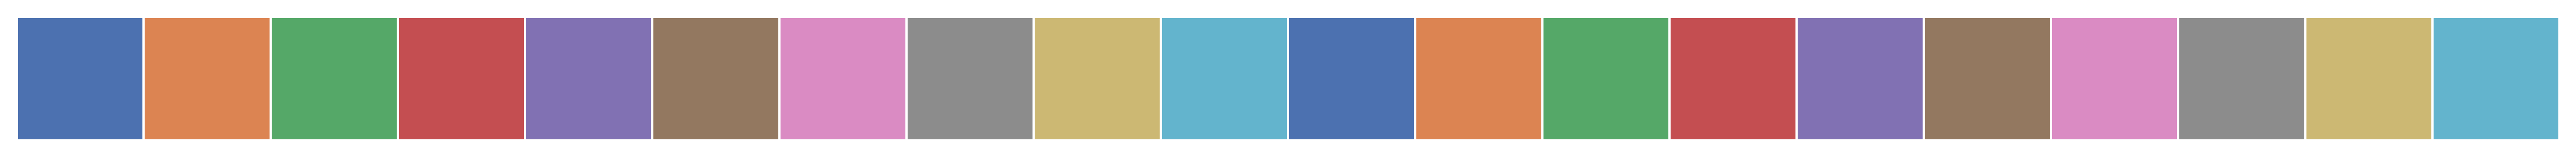

In [138]:
# setting plot parameters
plt.rcParams['axes.facecolor'] = 'lightgray'
np.set_printoptions(suppress = True, formatter={'float_kind': '{:.4f}'.format})
sns.set(style="darkgrid")

# color palatte for methods
COLOR_PALETTE = sns.color_palette(n_colors=20,desat=1.)
sns.palplot(COLOR_PALETTE)

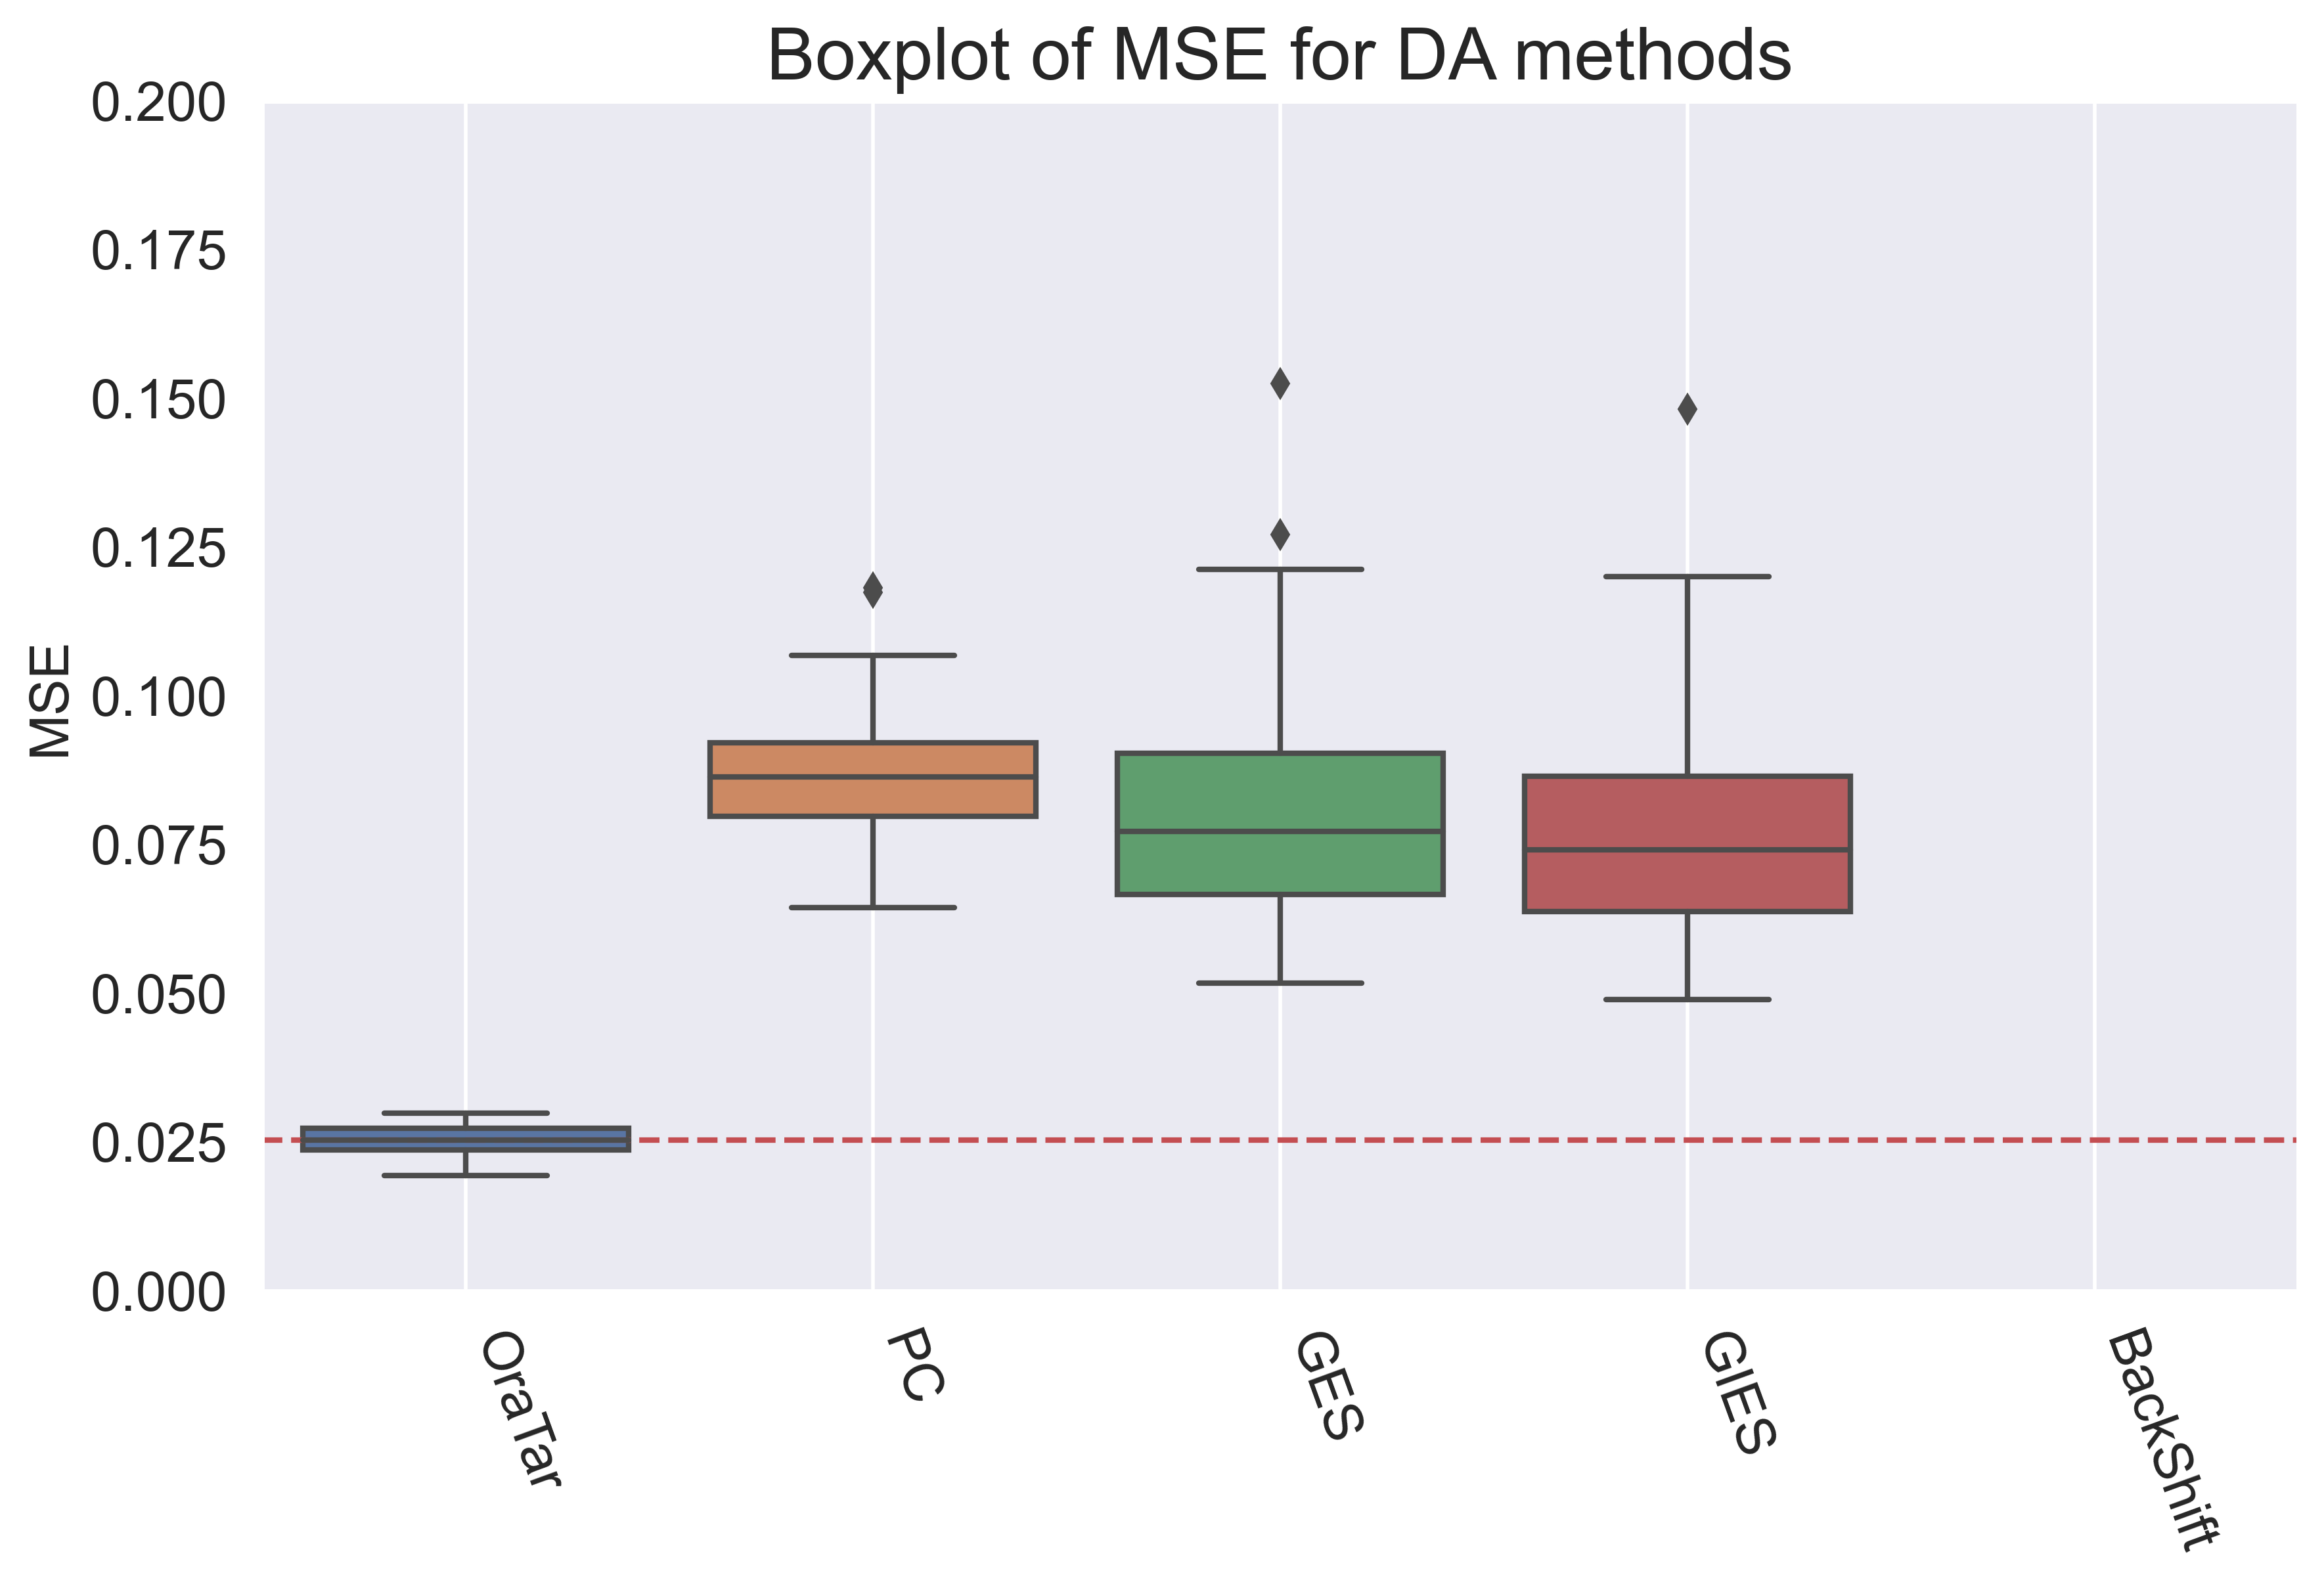

In [216]:
boxplot_all_methods(res_all_df, method_index=[0,16,17,18,19],title='Boxplot of MSE for DA methods',names=res_all_df.index,COLOR_PALETTE=COLOR_PALETTE,figsize = (10,6),ylim_option=0.2)
# causal structure learning --- causal: [0,15,16,17,18]; anticausal: [0,15,16,17,18]; hybrid: [0,16,17,18,19]
# without causal structure learning --- causal: [0,1,3,4,7,9,19,20,21]; anticausal: [0,1,3,4,5,6,7,19,20]; hybrid:[0,1,3,5,6,7,8,10,11,20,21,22]

In [77]:
index1 = 5
index2 = 10

nb_below_diag = np.sum(res_all[index1] <= res_all[index2])/len(res_all[index1])*100
scatterplot_two_methods(res_all, index1=index1, index2=index2, names=names_short, colors=COLOR_PALETTE[index1], title="%d%% of points above the diagonal" %nb_below_diag, figsize = (6,6), ylimmax = 0.03)